In [1]:
import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import torch

from qiskit import Aer
from tqdm.notebook import tqdm

import sys
sys.path.insert(0, '../../src/')
from neuralnetwork import *
from analysis import *
from samplers import *

%matplotlib notebook
#%matplotlib inline
%load_ext autoreload
%autoreload 2

### Pytorch network

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(1, 3)
        self.layer2 = torch.nn.Linear(3, 3)
        self.layer3 = torch.nn.Linear(3, 1)
        
        self.act = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.act(self.layer1(x))
        x = self.act(self.layer2(x))
        x = self.layer3(x)
        
        return x

torch.manual_seed(42)
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

np.random.seed(42)
#x = torch.linspace(0, 1, 10).reshape(-1,1)
#y = torch.tensor(np.random.uniform(0, 1, 10).reshape(-1,1))

x = torch.linspace(0, np.pi, 11).reshape(-1,1)
y = 0.9*torch.exp(-3*(x-np.pi/2)**2) + 0.05

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
for i in tqdm(range(200)):
    y_pred = model(x)
    loss = torch.mean((y_pred - y)**2)
    

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    ax.clear()
    ax.plot(x.detach(), y.detach(), "o")
    ax.plot(x.detach(), y_pred.detach(), "o")
    ax.set_ylim([0, 1])
    fig.canvas.draw()

### Classical network

In [ ]:
np.random.seed(42)
optimizer = Adam(lr=1e-1)

layer1 = Dense(n_features=1, n_targets=5, scale = 1, activation = Sigmoid())
layer2 = Dense(n_features=5, n_targets=5, scale = 1, activation = Sigmoid())
layer3 = Dense(n_features=5, n_targets=1, scale = 1, activation = Identity())
layers =[layer1, layer2, layer3]
network = NeuralNetwork(layers, optimizer)


x = np.linspace(0, np.pi, 11).reshape(-1,1)
y = 0.9*np.exp(-3*(x-np.pi/2)**2) + 0.05

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
for i in tqdm(range(200)):
    network.backward(x, y)
    network.step()
    y_pred = network.predict(x)
    
    loss = np.mean((y_pred - y)**2)
    
    
    ax.clear()
    ax.plot(x, y, "o")
    ax.plot(x, y_pred, "o")
    ax.set_ylim([0, 1])
    fig.canvas.draw()

### Hybrid network

In [2]:
np.random.seed(42)
optimizer = Adam(lr=1e-1)
backend = Aer.get_backend('qasm_simulator')

layer1 = Dense(n_features=1, 
               n_targets=3, 
               scale = 2*np.pi, 
               activation = Sigmoid())

layer2 = QLayer(n_qubits=3, 
                n_features=3, 
                n_targets=3, 
                encoder=Encoder(), 
                ansatz=Ansatz(), 
                sampler = Parity(),
                reps=1, 
                scale=2*np.pi, 
                backend=backend, shots=10000)

layer3 = QLayer(n_qubits=3, 
                n_features=3, 
                n_targets=3, 
                encoder=Encoder(), 
                ansatz=Ansatz(), 
                sampler = Parity(),
                reps=1, 
                scale=1, 
                backend=backend, shots=10000)

layer4 = Dense(n_features=3, 
               n_targets=1, 
               scale = 1, 
               activation = Identity())

layers =[layer1, layer2, layer3, layer4]
network = NeuralNetwork(layers, optimizer)

In [3]:
x = np.linspace(0, 1, 20).reshape(-1,1)
y = 0.9*np.exp(-10*(x-0.5)**2)
y = scaler(y, a=-2, b=2)

<IPython.core.display.Javascript object>


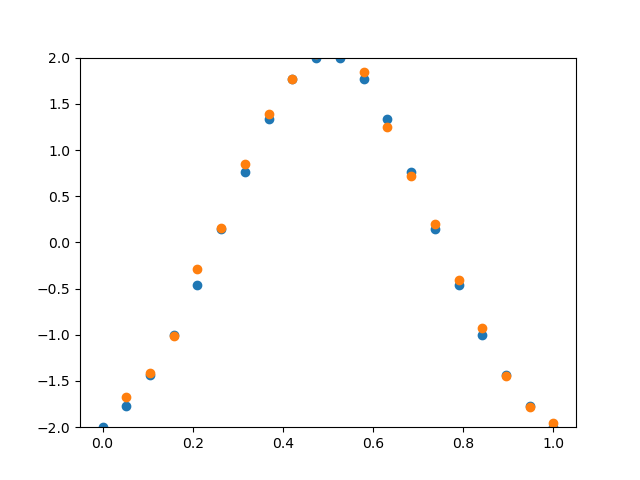

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
for i in tqdm(range(100)):
    network.backward(x, y)
    
    y_pred = network.predict(x)
    
    loss = np.mean((y_pred - y)**2)
    network.step()
    
    ax.clear()
    ax.plot(x, y, "o")
    ax.plot(x, y_pred, "o")
    ax.set_ylim([-2, 2])
    fig.canvas.draw()